In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import sys
# Get the current working directory
current_dir = os.getcwd()

# Append the src directory to the Python path
src_dir = os.path.join(current_dir, 'src')
sys.path.append(src_dir)

# Path to the config file
config_path = os.path.join(current_dir, 'config', 'config.yaml')
import utils

In [2]:
with open('config/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load in the datasets

In [3]:
x500r_df = pd.read_csv('Data/X500R_SMILES.csv')

In [4]:
bccdc_df = pd.read_csv('Data/training_data_bccdc.csv')

# Load in the ML Models from the scratch folder

In [5]:
import pickle

In [6]:
ml_models_dir = '/scratch/st-ashapi01-1/RADD/SMILES_ML_PIPELINE'
x500r_output_dir = 'X500R_output'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
import logging
import pickle
from sklearn import preprocessing
import math
import time
# Import the ML Models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf

2024-07-08 20:34:32.045462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 20:34:32.111317: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-08 20:34:32.112716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 20:34:37.793211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
all_models = []
for root, dirs, files in os.walk(os.path.join(ml_models_dir, x500r_output_dir, 'models')):
    for file in files:
        if file.endswith('.json'):
                json_file = open(root + '/' + file, 'r')
                loaded_model_json = json_file.read()
                loaded_model = model_from_json(loaded_model_json)
                all_models.append(loaded_model)
                json_file.close() 
        elif file.endswith('.pkl'):
            with open(root + '/' + file, 'rb') as f:
                all_models.append(pickle.load(f))
        elif file.endswith('.h5'):
            neural_net_weights = os.path.join(root, file)

for i in all_models:
    if isinstance(i, tf.keras.Model):
        i.load_weights(neural_net_weights)

# Read the preprocessor to encode the data for the models to predict on

In [9]:
with open(os.path.join(ml_models_dir, x500r_output_dir, 'processor.pkl'), 'rb') as f:
    processor = pickle.load(f)

This configuration is for X500R

In [10]:
## Load configurations
model_index = config['model_index']
model_y = config['model_y']
model_X = config['model_X']

In [11]:
import train
import test

In [12]:
# Instaniate the Encoder
vectorizer = train.SMILESVectorizer()

In [13]:
vectorizer.fit(x500r_df[model_X].to_list())

max_smiles_length: [79, 17, 21, 18, 20, 21, 16, 19, 22, 21, 19, 22, 19, 20, 21, 25, 23, 21, 25, 23, 26, 23, 25, 22, 25, 24, 27, 27, 25, 22, 24, 27, 23, 26, 24, 24, 47, 25, 25, 26, 28, 23, 21, 25, 27, 27, 26, 27, 27, 27, 27, 25, 29, 26, 26, 24, 26, 26, 24, 32, 24, 26, 29, 30, 28, 29, 25, 28, 29, 27, 30, 32, 30, 30, 29, 30, 25, 34, 28, 35, 31, 29, 31, 29, 29, 29, 31, 29, 29, 33, 31, 31, 29, 36, 27, 27, 33, 32, 26, 27, 27, 32, 32, 34, 30, 32, 30, 66, 35, 31, 33, 40, 41, 39, 38, 38, 34, 28, 31, 33, 31, 24, 33, 33, 30, 35, 35, 36, 31, 37, 33, 33, 34, 32, 31, 36, 101, 36, 32, 34, 31, 42, 37, 34, 36, 37, 27, 39, 36, 36, 32, 36, 37, 36, 34, 37, 35, 38, 36, 110, 37, 35, 37, 32, 41, 41, 36, 34, 36, 43, 41, 41, 43, 37, 39, 43, 42, 41, 33, 40, 38, 37, 39, 45, 38, 51, 41, 36, 53, 42, 35, 42, 42, 44, 44, 36, 46, 44, 36, 41, 37, 41, 532, 44, 40, 46, 23, 47, 41, 46, 44, 40, 44, 33, 44, 44, 44, 40, 45, 52, 42, 46, 46, 45, 39, 42, 41, 42, 54, 45, 37, 40, 43, 36, 38, 91, 42, 47, 43, 46, 49, 47, 42, 42, 4

In [14]:
x500r_df_vectorized, _ = vectorizer.transform(x500r_df[model_X].to_list())

# Flatten and create feature names
x500r_df_flattened = train.flatten_and_create_feature_names(x500r_df_vectorized)

# Combine with additional features (assuming no additional features in this example)
combined_x500r_df = train.combine_with_additional_features(x500r_df_flattened, None)

In [15]:
norm_X = processor.transform(combined_x500r_df)

In [16]:
for model in all_models:
    print(model.predict(norm_X))

[ 6.00381226  4.63706539  4.71069647  4.63706539  4.55942651  4.54089989
  4.64762035  4.15814656  4.71069647  4.63706539  4.75858111  4.87264776
  4.63706539  4.6693258   4.61027842  4.60812946  4.66597556  4.06764872
  4.65111918  3.49794461  4.68137909  4.83118403  4.66250134  4.73553747
  4.40081022  4.67331978  4.79201564  4.13496035  4.68135142  4.82118367
  3.48473336  4.22605475  3.86002481  4.6598988   4.83118403  4.72360463
  6.04373166  5.0625995   4.60812946  4.61886691  4.65206944  4.55298917
  4.70626005  4.60812946  4.7582542   4.71069647  4.6189702   4.71758385
  3.48473336  3.48473336  4.70507801  4.5486379   4.89717823  4.94638297
  4.54508565  4.70507801  4.65911088  4.67331978  4.68773344  5.12427525
  4.72879003  4.75858111  5.11280362  6.00040682  4.83118403  5.13784505
  4.84852114  4.29481275  5.11266696  4.80677002  5.17535681  4.86711228
  5.28221455  5.4792893   5.46386121  4.68773344  4.93704656  5.41459281
  4.6646503   6.38089131  4.63614925  4.73102405  5

In [17]:
model_names = config['model_names']

In [18]:
x500r_col_names = []
for i,name in enumerate(model_names):
    x500r_col_names.append(name + '_prediction')
    x500r_df[name + '_prediction'] = all_models[i].predict(norm_X)

26/26 [==============================] - 0s 7ms/step
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


In [19]:
def make_error_bins(df):
    # Calculate errors
    for model in model_names:
        df[f'{model}_error'] = abs(df[model+'_prediction'] - df[model_y])

    # Convert to long format manually
    long_data = []
    for index, row in df.iterrows():
        for model in model_names:
            if model != 'model_y':
                long_data.append({
                    'Compound' : row[model_X],
                    'Actual RT': row[model_y],
                    'model': model,
                    'prediction': row[model+'_prediction'],
                    'error': row[f'{model}_error'],
                    'under_over': 'Under' if row[model+'_prediction'] < row[model_y] else 'Over'
                })

    df_long = pd.DataFrame(long_data)

    # Function to bin errors
    def bin_errors(error):
        if error <= 1.0:
            return '<= 1.0'
        elif 1.0 < error <= 2.0:
            return '> 1.0 and <= 2.0'
        else:
            return '> 2.0'

    # Apply binning
    df_long['error_bin'] = df_long['error'].apply(bin_errors)
    return df_long

In [20]:
x500r_df.head()

,Non-Targeted,IS,Group,Name,Chemical Formula,Isotope,Adduct/Charge,Gain/Loss,Precursor (Q1) Mass (Da),Fragment (Q3) Mass (Da),...,Regression Type,Regression Weighting,Signal-to-Noise Algorithm,SMILES,CatBoost_prediction,Lasso_prediction,LGBM_prediction,Neural Network_prediction,Random Forest_prediction,XGBoost_prediction
0,False,False,NaN,Tranylcypromine,C9H11N,1,[M+H]+,NaN,133.089149,NaN,...,Linear,1 / x,RelativeNoise,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,6.003812,6.898445,5.463232,5.840818,5.469240,6.121424
1,False,False,NaN,Amphetamine,C9H13N,1,[M+H]+,NaN,135.104800,NaN,...,Linear,1 / x,RelativeNoise,CC(CC1=CC=CC=C1)N,4.637065,5.078158,3.601117,3.781483,3.702625,4.004751
2,False,False,NaN,Cathinone,C9H11NO,1,[M+H]+,NaN,149.084064,NaN,...,Linear,1 / x,RelativeNoise,CC(C(=O)C1=CC=CC=C1)N,4.710696,5.345087,4.199670,3.959048,3.754715,4.022824
3,False,False,NaN,Methamphetamine,C10H15N,1,[M+H]+,NaN,149.120450,NaN,...,Linear,1 / x,RelativeNoise,CC(CC1=CC=CC=C1)NC,4.637065,5.078158,3.856006,3.788230,3.782397,3.921770
4,False,False,NaN,Phentermine,C10H15N,1,[M+H]+,NaN,149.120450,NaN,...,Linear,1 / x,RelativeNoise,CC(C)(CC1=CC=CC=C1)N,4.559427,5.512625,4.207755,4.121913,3.761788,4.368595


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
def error_bin_plots(df_long, output_dir, filename='error_plots.png'):
    # Plotting with seaborn
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_long, x='model', hue='error_bin')
    plt.title('Error Distribution Across Models')
    plt.xlabel('Model')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Error Bin')
    plt.tight_layout()
    plt.show()
    plt.savefig(os.path.join(output_dir, filename))

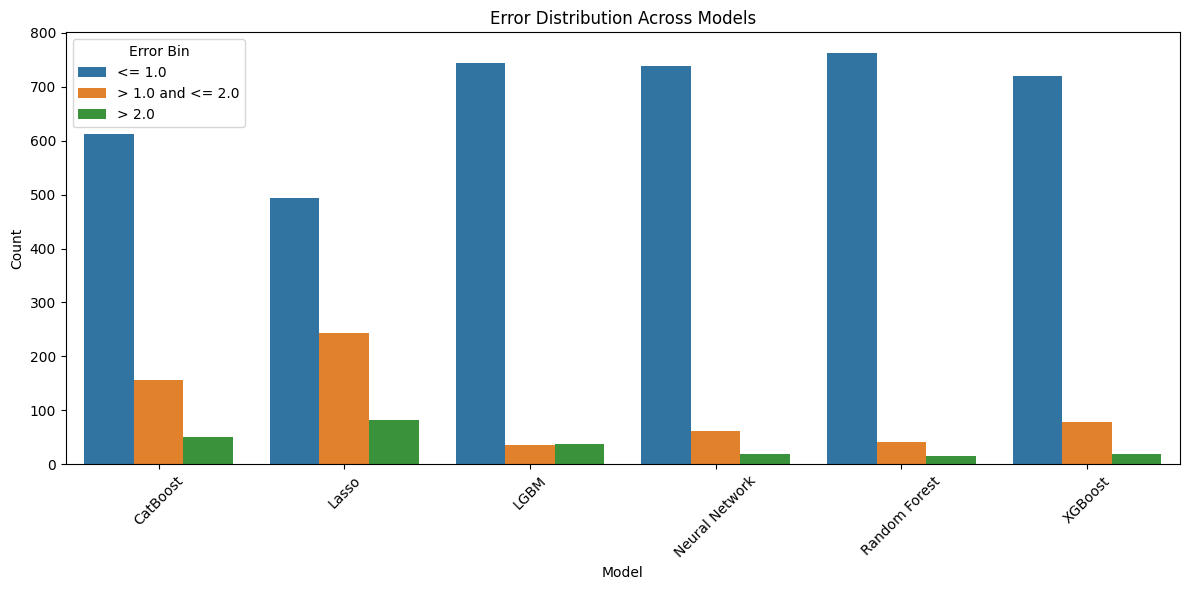

<Figure size 640x480 with 0 Axes>

In [23]:
x500r_plot_df = make_error_bins(x500r_df)
error_bin_plots(x500r_plot_df, 'Figures', 'error_x500r_plots.png')

In [24]:
x500r_plot_df.head()

,Compound,Actual RT,model,prediction,error,under_over,error_bin
0,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,5.45,CatBoost,6.003812,0.553812,Over,<= 1.0
1,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,5.45,Lasso,6.898445,1.448445,Over,> 1.0 and <= 2.0
2,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,5.45,LGBM,5.463232,0.013232,Over,<= 1.0
3,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,5.45,Neural Network,5.840818,0.390818,Over,<= 1.0
4,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...,5.45,Random Forest,5.469240,0.019240,Over,<= 1.0


# Test it on the BCCDC cohort

In [25]:
vectorizer = train.SMILESVectorizer()

In [26]:
bccdc_df.dropna(subset=[model_X], inplace=True)

In [27]:
model_y = 'PTC Confirmed RT'
model_index = 'Compound'

In [28]:
vectorizer.fit(x500r_df[model_X].to_list())

max_smiles_length: [79, 17, 21, 18, 20, 21, 16, 19, 22, 21, 19, 22, 19, 20, 21, 25, 23, 21, 25, 23, 26, 23, 25, 22, 25, 24, 27, 27, 25, 22, 24, 27, 23, 26, 24, 24, 47, 25, 25, 26, 28, 23, 21, 25, 27, 27, 26, 27, 27, 27, 27, 25, 29, 26, 26, 24, 26, 26, 24, 32, 24, 26, 29, 30, 28, 29, 25, 28, 29, 27, 30, 32, 30, 30, 29, 30, 25, 34, 28, 35, 31, 29, 31, 29, 29, 29, 31, 29, 29, 33, 31, 31, 29, 36, 27, 27, 33, 32, 26, 27, 27, 32, 32, 34, 30, 32, 30, 66, 35, 31, 33, 40, 41, 39, 38, 38, 34, 28, 31, 33, 31, 24, 33, 33, 30, 35, 35, 36, 31, 37, 33, 33, 34, 32, 31, 36, 101, 36, 32, 34, 31, 42, 37, 34, 36, 37, 27, 39, 36, 36, 32, 36, 37, 36, 34, 37, 35, 38, 36, 110, 37, 35, 37, 32, 41, 41, 36, 34, 36, 43, 41, 41, 43, 37, 39, 43, 42, 41, 33, 40, 38, 37, 39, 45, 38, 51, 41, 36, 53, 42, 35, 42, 42, 44, 44, 36, 46, 44, 36, 41, 37, 41, 532, 44, 40, 46, 23, 47, 41, 46, 44, 40, 44, 33, 44, 44, 44, 40, 45, 52, 42, 46, 46, 45, 39, 42, 41, 42, 54, 45, 37, 40, 43, 36, 38, 91, 42, 47, 43, 46, 49, 47, 42, 42, 4

In [29]:
bccdc_df_vectorized, _ = vectorizer.transform(bccdc_df[model_X].to_list())

# Flatten and create feature names
bccdc_df_flattened = train.flatten_and_create_feature_names(bccdc_df_vectorized)

# Combine with additional features (assuming no additional features in this example)
combined_bccdc_df = train.combine_with_additional_features(bccdc_df_flattened, None)

In [30]:
combined_bccdc_df.head()

,pos_0_char_0,pos_0_char_1,pos_0_char_2,pos_0_char_3,pos_0_char_4,pos_0_char_5,pos_0_char_6,pos_0_char_7,pos_0_char_8,pos_0_char_9,...,pos_532_char_29,pos_532_char_30,pos_532_char_31,pos_532_char_32,pos_532_char_33,pos_532_char_34,pos_532_char_35,pos_532_char_36,pos_532_char_37,pos_532_char_38
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
norm_X = processor.transform(combined_bccdc_df)

In [32]:
combined_x500r_df.head()

,pos_0_char_0,pos_0_char_1,pos_0_char_2,pos_0_char_3,pos_0_char_4,pos_0_char_5,pos_0_char_6,pos_0_char_7,pos_0_char_8,pos_0_char_9,...,pos_532_char_29,pos_532_char_30,pos_532_char_31,pos_532_char_32,pos_532_char_33,pos_532_char_34,pos_532_char_35,pos_532_char_36,pos_532_char_37,pos_532_char_38
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
for model in all_models:
    print(model.predict(norm_X))

[4.3116359  4.87621135 5.46431763 5.93383342 6.67964806 7.14245134
 6.60626629 7.84874335 6.7245199  7.37365133 7.32116635 4.7762915
 7.20555582 6.37315359 7.05599228 6.89080694 4.63706539 5.26569486
 6.21182871 5.59529665 5.59536757 6.78320474 7.08695927 6.04009812
 6.0128765  8.96469288 5.44608255 7.29455835 5.0451911  7.12315942
 6.02312366 6.55456666 6.04009812 6.87954135 6.98327034 7.43840577
 6.54667431 7.10109609 7.05100938 7.35310326 6.00752556 5.09261616
 6.54109409 6.3865059  6.43545543 6.6384388  7.99396247 6.72460556
 7.10109609 3.65335974 6.03269486 5.65868473 7.45793394 5.83234301
 7.04686418 6.01596461 6.87109091 7.0642099  5.48230006 6.36987728
 7.31247686 6.63566957 6.72625189 7.32116635 7.31727999 7.27576789
 7.30472638 6.90985909 7.78696845 4.61027842 6.72364933 6.84927944
 4.70626005 6.02172788 4.61642637 5.44608255 7.05181867 6.4202929
 6.4218004  7.18582816 5.6260454  4.6189702  4.6693258  5.27156176
 7.62906405 7.24492084 6.16131291 6.78598465 4.60812946 5.756522

In [34]:
bccdc_col_names = []
for i,name in enumerate(model_names):
    bccdc_col_names.append(name + '_prediction')
    bccdc_df[name + '_prediction'] = all_models[i].predict(norm_X)

6/6 [==============================] - 0s 9ms/step
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


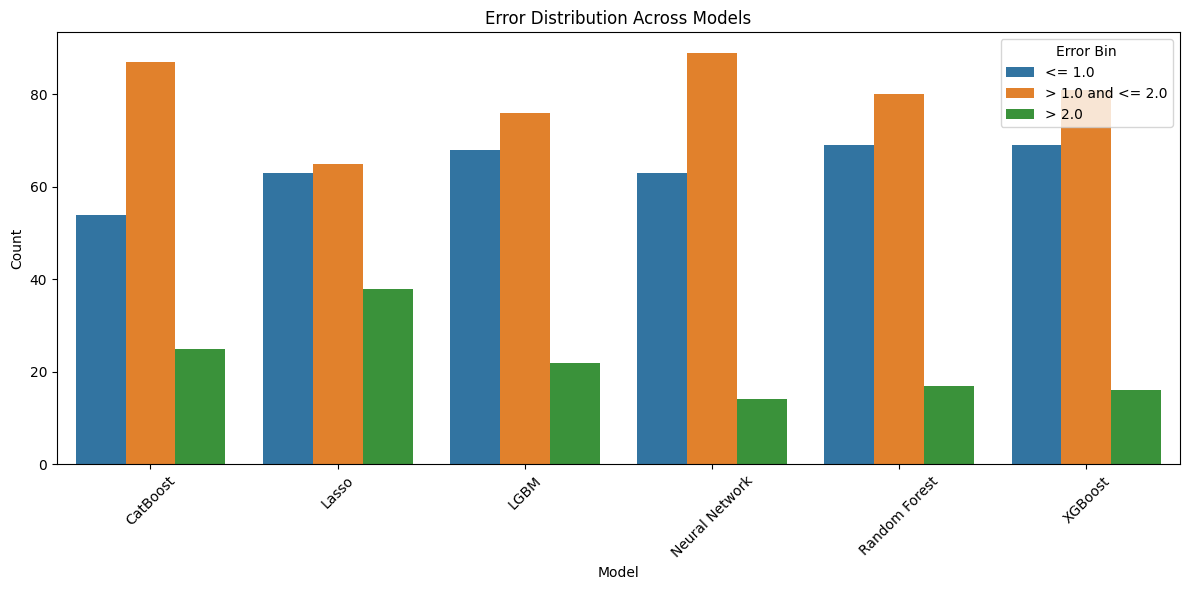

<Figure size 640x480 with 0 Axes>

In [35]:
bccdc_plot_df = make_error_bins(bccdc_df)
error_bin_plots(bccdc_plot_df, 'Figures', 'error_bccdc_plots.png')

# Save Long Formats for Presentation

In [36]:
x500r_plot_df.to_csv('Analysis/x500r_with_error_bins.csv', index=False)
bccdc_plot_df.to_csv('Analysis/bccdc_with_error_bins.csv', index=False)